**1. Read and import data**

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [82]:
dataset = pd.read_csv('./data/salary.csv', sep='|')

In [83]:
dataset.head(2)

,id,job_title,location,salary_currency,career_level,experience_level,education_level,employment_type,job_function,job_benefits,company_process_time,company_size,company_industry,job_description,salary
0,1,Facility Maintenance & Smart Warehouse Manager,Bandung,IDR,Manajer/Asisten Manajer,5 tahun,"Sertifikat Professional, D3 (Diploma), D4 (Dip...",Penuh Waktu,"Manufaktur,Pemeliharaan",NaN,NaN,NaN,NaN,Deskripsi PekerjaanRequirements :D3/SI from re...,NaN
1,2,Procurement Department Head,Jakarta Raya,IDR,Manajer/Asisten Manajer,5 tahun,"Sarjana (S1), Diploma Pascasarjana, Gelar Prof...",Penuh Waktu,"Manufaktur,Pembelian/Manajemen Material",NaN,25 days,51 - 200 pekerja,Manajemen/Konsulting HR,Job Role: 1. Responsible for material availabi...,NaN


**2. Cleaning the data**

In [84]:
# Remove Column & Null Value 
dataset = dataset.drop(labels=["id", "salary_currency", "job_benefits", "job_function", "job_description",
"company_process_time", "company_size", "company_industry"], axis=1)
dataset.dropna(inplace=True)

In [85]:
dataset.head(2)

,job_title,location,career_level,experience_level,education_level,employment_type,salary
9,Tax Supervisor,Banten,Supervisor/Koordinator,3 tahun,"Sertifikat Professional, D3 (Diploma), D4 (Dip...",Penuh Waktu,8000000.0
18,Accounting Staff,Jakarta Pusat,Pegawai (non-manajemen & non-supervisor),1 tahun,"SMA, SMU/SMK/STM, Sertifikat Professional, D3 ...",Penuh Waktu,4750000.0


In [86]:
# Nampilin tipe kolom "Object" & "Number"
objectType  = dataset.select_dtypes(['object']).columns
numericType  = dataset.select_dtypes(['number']).columns
print(objectType)
print(numericType)

Index(['job_title', 'location', 'career_level', 'experience_level',
       'education_level', 'employment_type'],
      dtype='object')
Index(['salary'], dtype='object')


In [87]:
# Check null values
dataset.isnull().sum()

job_title           0
location            0
career_level        0
experience_level    0
education_level     0
employment_type     0
salary              0
dtype: int64

In [88]:
dataset[numericType].describe()

,salary
count,8.570000e+03
mean,7.637237e+06
std,2.241025e+07
min,1.000000e+01
25%,4.371250e+06
50%,5.700000e+06
75%,8.400000e+06
max,2.000000e+09


**3. Discovering the data**

Top 10 Region Have The Highest Average Salary

In [89]:
topRegion = dataset[["location","salary"]]
topRegion = topRegion[(topRegion.groupby(['location'])['location'].transform('count') > 10)]
topRegion.set_index("location", inplace=True)

In [90]:
topRegion.groupby(['location'])['salary'].mean().astype(int).nlargest(10)

location
Sumatera Utara        11177024
Kalimantan Tengah     10619230
Tangerang             10316543
Jakarta Raya           9666784
Sulawesi Tengah        9529166
Aceh                   9482228
Kalimantan Timur       9442307
Jakarta Selatan        9286904
Bali                   9199430
Kalimantan Selatan     8325000
Name: salary, dtype: int32

Kind of Career Level

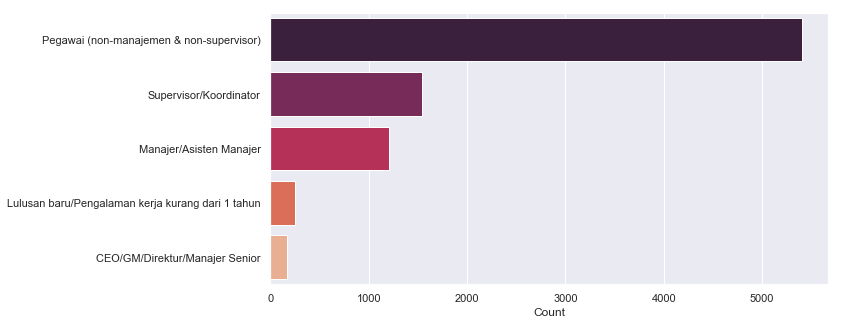

In [91]:
countCL = sns.load_dataset("tips")
sns.set(rc={'figure.figsize':(10, 5)})
sns.countplot(data = countCL, y = dataset["career_level"], palette="rocket", order = dataset["career_level"].value_counts().index)
plt.xlabel("Count")
plt.ylabel("")
plt.show()

Average Salary based on Career Level

In [92]:
dataset.groupby(by="career_level")["salary"].mean().round(0).astype("int").nlargest()

career_level
CEO/GM/Direktur/Manajer Senior                       25860062
Manajer/Asisten Manajer                              13017445
Supervisor/Koordinator                                7754286
Pegawai (non-manajemen & non-supervisor)              5960257
Lulusan baru/Pengalaman kerja kurang dari 1 tahun     4812583
Name: salary, dtype: int32

Kind of Experience Level

In [93]:
dataset["experience_level"] = dataset["experience_level"].str.replace("\D", "").fillna(0).astype('int')

In [94]:
type_exp = []
for i in dataset['experience_level']:
    if i == 0:
        type_exp.append('No Experience')
    elif 1 <= i <= 4:
        type_exp.append('1-4 Years')
    elif 5 <= i <= 9:
        type_exp.append('5-9 Years')
    elif 10 <= i <= 14:
        type_exp.append('10-14 Years') 
    elif 15 <= i <= 19:
        type_exp.append('15-19 Years')            
    else:
        type_exp.append('20+ Years')
dataset['type_of_experience'] = type_exp

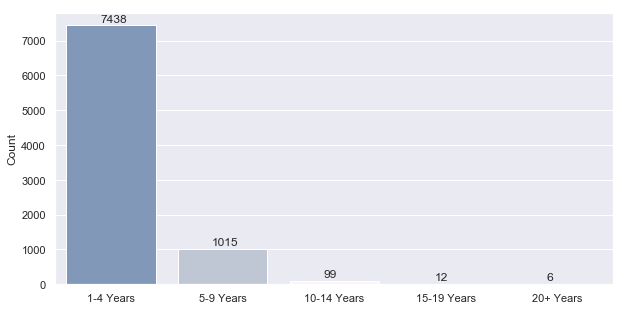

In [95]:
countEXP = sns.load_dataset("tips")
barExp = sns.countplot(data = countCL, x = dataset["type_of_experience"], palette="vlag", order = dataset["type_of_experience"].value_counts().index)
plt.ylabel("Count")
plt.xlabel("")

for p, label in zip(barExp.patches, dataset["type_of_experience"].value_counts()):
    barExp.annotate(label, (p.get_x() + 0.3, p.get_height() + 100))
    
plt.show()

Average Salary based on Experience Level

In [96]:
dataset.groupby(by="type_of_experience")["salary"].mean().round(0).astype("int").nlargest() 

type_of_experience
20+ Years      36583333
15-19 Years    31680000
10-14 Years    27304702
5-9 Years      12678566
1-4 Years       6625376
Name: salary, dtype: int32

**4. Predict the salary**

Predict Salary Based on Experience

In [97]:
dataset = dataset[dataset.salary > 100000]
dataset = dataset[dataset["salary"] < dataset["salary"].max()]

In [98]:
xYear = dataset.loc[:, ["experience_level"]].values
ySalary = dataset.loc[:, ["salary"]].values

xTrain, xTest, yTrain, yTest = train_test_split(xYear, ySalary, test_size = 1/3)
predictExpSal = LinearRegression()
predictExpSal.fit(xTrain, yTrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

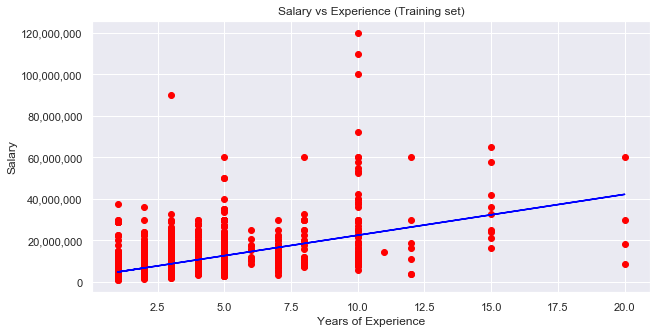

In [99]:
plt.scatter(xTrain, yTrain, color = 'red')
plt.plot(xTrain, predictExpSal.predict(xTrain), color = 'blue')
plt.title('Salary vs Experience (Training set)')
plt.xlabel('Years of Experience')
plt.ylabel('Salary')

formatSal = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(i) for i in formatSal])

plt.show()

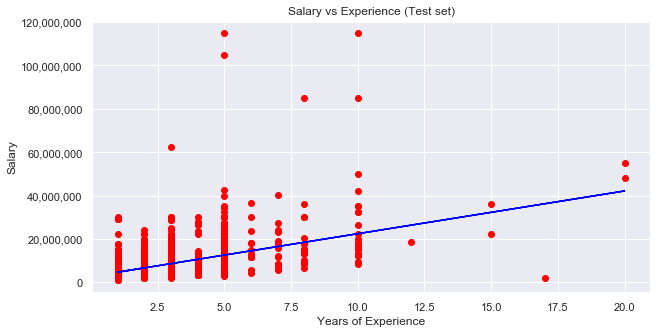

In [100]:
plt.scatter(xTest, yTest, color = 'red')
plt.plot(xTrain, predictExpSal.predict(xTrain), color = 'blue')
plt.title('Salary vs Experience (Test set)')
plt.xlabel('Years of Experience')
plt.ylabel('Salary')

plt.gca().set_yticklabels(['{:,.0f}'.format(i) for i in formatSal])

plt.show()

In [101]:
# Memprediksi gaji dengan experience level
# model.predict(year)
predictExpSal.predict([[10]])

array([[22434455.49650713]])